# Evaluación 1 - Entrenando redes feedforward

**Autores:**

+ Aldo Miguel Arroyo Castro
+ Juan Luis Vicente Bórquez Ormeño

**Correos Electrónicos:**

+ ald.arroyo@duocuc.cl
+ jua.borquez@duocuc.cl

**Fecha de Creación:** Abril de 2025  
**Versión:** 1.0  

---

## Descripción

Este notebook contiene el desarrollo de la evaluación 1 de la asignatura de Deep Learning de la carrera de Ingeniería en Informática de DuocUC sede Concepción.

---

## Requisitos de Software

Este notebook fue desarrollado con Python ...

# Introducción

TODO

# Carga de datos y preprocesamiento de datos

In [1]:
import gzip
import shutil
import struct
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import pandas as pd
import sys
import os

from tensorflow.keras.models import load_model
from tensorflow import keras
# Asegurar que las etiquetas están en formato correcto
from keras.utils import to_categorical

2025-04-20 00:32:49.646701: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-20 00:32:49.708122: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-20 00:32:49.708200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-20 00:32:49.709631: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-20 00:32:49.719812: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print("TensorFlow Version:", tf.__version__)
print("Python version:", sys.version)

TensorFlow Version: 2.15.1
Python version: 3.11.10 (main, Feb 13 2025, 15:40:15) [GCC 10.2.1 20210110]


In [3]:
if (os.path.exists("train-images-idx3-ubyte.gz") and os.path.exists("train-labels-idx1-ubyte.gz") and os.path.exists("t10k-images-idx3-ubyte.gz") and os.path.exists("t10k-labels-idx1-ubyte.gz")):
    print("Datasets already downloaded")
else:
    !rm -f train-images-idx3-ubyte.gz train-labels-idx1-ubyte.gz t10k-images-idx3-ubyte.gz t10k-labels-idx1-ubyte.gz

    !wget https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz
    !wget https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz
    !wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz
    !wget https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz


Datasets already downloaded


In [4]:
!ls -lh | grep 'gz'

-rw-r--r--. 1 root users 1.6M Apr  6  2017 t10k-images-idx3-ubyte.gz
-rw-r--r--. 1 root users 4.5K Apr  6  2017 t10k-labels-idx1-ubyte.gz
-rw-r--r--. 1 root users 9.5M Apr  6  2017 train-images-idx3-ubyte.gz
-rw-r--r--. 1 root users  29K Apr  6  2017 train-labels-idx1-ubyte.gz


## Funciones

En esta sección se definen función que serán de utlidad en el resto de este jupyter notebook

Función que toma el historial de los entrenamiento y devuelve resultado como df

In [5]:
def generate_metrics_table_from_histories(models):
    # Chequear que sea una lista
    if not isinstance(models, list):
        models = [models]
        single_model = True
    else:
        single_model = len(models) == 1

    results = []
    for hist in models:
        final_epoch = {}
        for metric, values in hist.history.items():
            # Extraer el valor escalar de la última época
            last_value = values[-1]
            if isinstance(last_value, (list, np.ndarray)):
                last_value = np.mean(last_value)  # O puedes usar last_value[-1] si prefieres solo la última clase
            final_epoch[metric] = last_value
        result = {"Modelo": hist.name, **final_epoch}
        results.append(result)

    results_df = pd.DataFrame(results)

    if single_model:
        results_df = results_df.drop(columns="Modelo")

    return results_df

Función que extrae los hiperparametros de las redes

In [6]:
def extraer_info_redes(nombres_redes):
    data = []

    for nombre_red in nombres_redes:
        modelo = globals()[nombre_red]  # Accede a la red por su nombre en string

        # Nombre
        nombre = modelo.name

        # Función de activación (busca la capa con atributo 'activation')
        funcion_activacion = "N/A"
        for capa in modelo.layers:
            if hasattr(capa, 'activation'):
                funcion_activacion = capa.activation.__name__
                break

        # Dropout rate si hay alguna capa Dropout
        dropout_rate = 0
        for capa in modelo.layers:
            if isinstance(capa, keras.layers.Dropout):
                dropout_rate = capa.rate
                break

        # Optimizador
        optimizador = modelo.optimizer.__class__.__name__

        # Learning rate
        learning_rate = float(modelo.optimizer.learning_rate.numpy())
        learning_rate = round(learning_rate, 4)

        # Agregar a la tabla
        data.append([nombre, funcion_activacion, dropout_rate, optimizador, learning_rate])

    # Mostrar como tabla
    df = pd.DataFrame(data, columns=["Nombre Red", "Función de Activación", "Tasa de Dropout", "Optimizador", "Learning Rate"])
    return df

Función que entrega un grafico de barras de la precisión del historial de los modelos

In [76]:
def plot_accuracy_bars(history, titulo="Precisión por época", sub_titulo="", ax=None):
    epochs = np.arange(len(history.history['accuracy']))
    bar_width = 0.4

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    min_acc = min(min(train_acc), min(val_acc))
    y_min = max(min_acc - 0.02, 0)  # límite inferior para el eje y

    # Crear el eje si no se proporciona
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    bars1 = ax.bar(epochs - bar_width/2, train_acc, width=bar_width, label='Entrenamiento', color='lightblue')
    bars2 = ax.bar(epochs + bar_width/2, val_acc, width=bar_width, label='Testing', color='lightgreen')

    # Etiquetas encima de cada barra
    for i in range(len(epochs)):
        ax.text(epochs[i] - bar_width/2, train_acc[i] + 0.001, f"{train_acc[i]:.3f}", ha='center', va='bottom', fontsize=9)
        ax.text(epochs[i] + bar_width/2, val_acc[i] + 0.001, f"{val_acc[i]:.3f}", ha='center', va='bottom', fontsize=9)

    ax.plot(epochs, train_acc, color='darkblue', linestyle='-', marker='o', label='Tendencia Entrenamiento')
    ax.plot(epochs, val_acc, color='darkgreen', linestyle='-', marker='o', label='Tendencia Testing')

    ax.set_xlabel('Época')
    ax.set_ylabel('Precisión')
    ax.set_title(f"{titulo}\n{sub_titulo}", fontsize=14, fontweight='bold')
    ax.set_xticks(epochs)
    ax.set_ylim(y_min, 1.0)
    ax.legend()
    ax.grid(True, axis='y')


In [79]:
def plot_loss_bars(history, titulo="Pérdida por época", sub_titulo="", ax=None):
    epochs = np.arange(len(history.history['accuracy']))
    bar_width = 0.4

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    min_loss = min(min(train_loss), min(val_loss))
    max_loss = max(max(train_loss), max(val_loss))
    y_min = max(min_loss - 0.02, 0)  # límite inferior para el eje y
    y_max = min(max_loss + 0.02, 1.0)  # límite superior para el eje y

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    bars1 = ax.bar(epochs - bar_width/2, train_loss, width=bar_width, label='Entrenamiento', color='lightblue')
    bars2 = ax.bar(epochs + bar_width/2, val_loss, width=bar_width, label='Testing', color='lightgreen')

    # Etiquetas encima de cada barra
    for i in range(len(epochs)):
        ax.text(epochs[i] - bar_width/2, train_loss[i] + 0.001, f"{train_loss[i]:.3f}", ha='center', va='bottom', fontsize=9)
        ax.text(epochs[i] + bar_width/2, val_loss[i] + 0.001, f"{val_loss[i]:.3f}", ha='center', va='bottom', fontsize=9)

    ax.plot(epochs, train_loss, color='darkblue', linestyle='-', marker='o', label='Tendencia Entrenamiento')
    ax.plot(epochs, val_loss, color='darkgreen', linestyle='-', marker='o', label='Tendencia Testing')

    ax.set_xlabel('Época')
    ax.set_ylabel('Pérdida')
    ax.set_title(f"{titulo}\n{sub_titulo}", fontsize=14, fontweight='bold')
    ax.set_xticks(epochs)
    ax.set_ylim(y_min, y_max)
    ax.legend()
    ax.grid(True, axis='y')

Función que entrega un grafico de barras de la perdida del historial de los modelos

In [9]:
def plot_execution_times(tiempos, modelos = ['Sin Dropout', 'Con Dropout'], colores = ['skyblue', 'lightgreen'], titulo="Tiempo de Ejecución", sub_titulo=""):
    fig, ax = plt.subplots(figsize=(8, 4))

    # Crear las barras con colores distintos
    bars = ax.barh(modelos, tiempos, color=colores, label='Tiempo de Ejecución (segundos)')

    # Agregar los valores al final de cada barra
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}',
                va='center', fontsize=12)

    # Etiquetas y formato
    ax.set_xlabel('Tiempo de Ejecución (segundos)')
    ax.set_ylabel('Modelo')
    ax.set_title(f'{titulo}\n{sub_titulo}')
    ax.grid(True, axis='x')

    plt.tight_layout()
    plt.show()

# Carga de imágenes

El conjunto de datos MNIST (Modified National Institute of Standards and Technology) es una base de imágenes ampliamente utilizada en tareas de clasificación. Contiene dígitos escritos a mano del 0 al 9, representados en imágenes en escala de grises de 28x28 píxeles. El dataset está compuesto por 60.000 imágenes para entrenamiento y 10.000 para prueba, cada una etiquetada con el número correspondiente. Es una herramienta estándar en el aprendizaje automático para evaluar modelos de reconocimiento de patrones. En Keras, puede cargarse fácilmente mediante su API integrada, que gestiona la descarga y preparación del conjunto de manera automática.

In [10]:
# Función para cargar imágenes MNIST
def load_mnist_images(filename):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)  # Saltar los primeros 16 bytes del encabezado
    return data.reshape(-1, 28 * 28).astype("float32") / 255.0  # Aplanar y normalizar

# Función para cargar etiquetas MNIST
def load_mnist_labels(filename):
    with gzip.open(filename, 'rb') as f:
        labels = np.frombuffer(f.read(), np.uint8, offset=8)  # Saltar los primeros 8 bytes del encabezado
    return keras.utils.to_categorical(labels, 10)  # One-hot encoding para clasificación

# Cargar los datos
X_train = load_mnist_images("train-images-idx3-ubyte.gz")
y_train = load_mnist_labels("train-labels-idx1-ubyte.gz")
X_test = load_mnist_images("t10k-images-idx3-ubyte.gz")
y_test = load_mnist_labels("t10k-labels-idx1-ubyte.gz")

# Verificar dimensiones
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_train: (60000, 784), y_train: (60000, 10)
X_test: (10000, 784), y_test: (10000, 10)


In [11]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

# Muestra imágenes

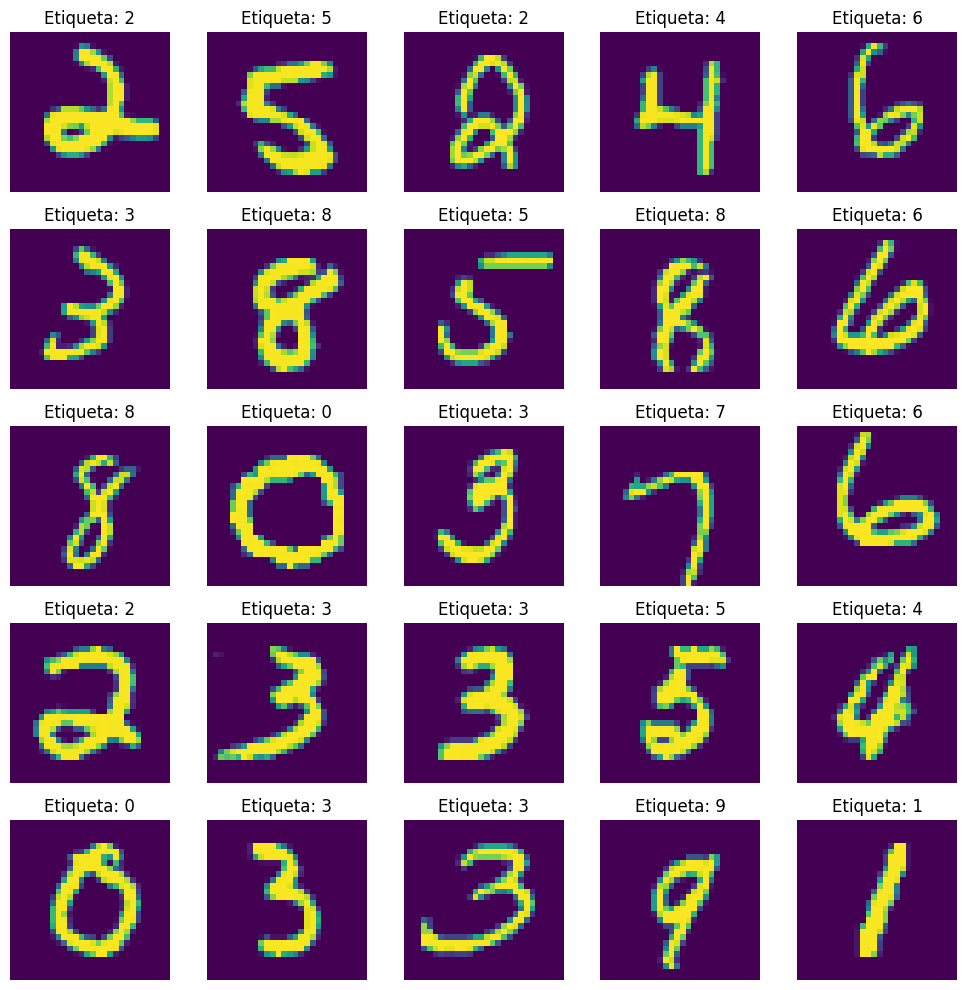

In [12]:
h = 5  # alto de la grilla
w = 5  # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(2*w, 2*h))

for i in range(h):
    for j in range(w):
        ex = np.random.randint(len(X_test))
        axs[i, j].imshow(X_test[ex].reshape(28, 28))
        axs[i, j].set_title(f"Etiqueta: {np.argmax(y_test[ex])}")
        axs[i, j].axis('off')  # Oculta los ejes

plt.tight_layout()
plt.show()

# Balance de clases

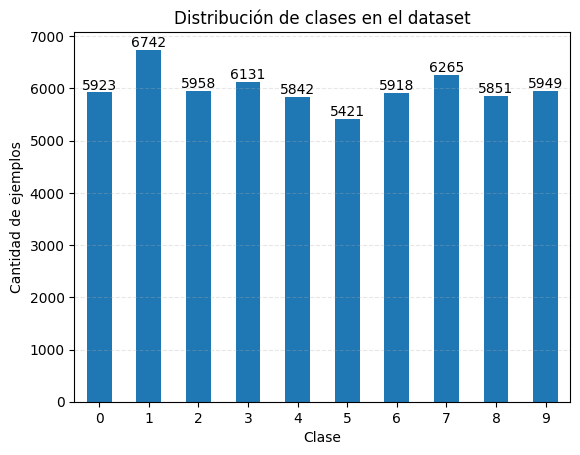

In [13]:
y_train_raw = np.argmax(y_train, axis=1)

df_balance = pd.DataFrame({"label": y_train_raw})

counts = df_balance['label'].value_counts().sort_index()

ax = counts.plot(kind='bar')

for i, value in enumerate(counts):
    ax.text(i, value, str(value), ha='center', va='bottom')

plt.xlabel("Clase")
plt.ylabel("Cantidad de ejemplos")
plt.title("Distribución de clases en el dataset")
plt.grid(axis='y', linestyle="--", alpha=0.3)
plt.xticks(rotation=0)
plt.show()

Se observa una asimetría en los datos. La clase 5 tiene la menor cantidad de muestras, lo que podría afectar negativamente el rendimiento del modelo al evaluar esta clase. Por otro lado, la clase 1 tiene la mayor cantidad de muestras, lo que podría generar un sesgo en los modelos hacia predecir este número con mayor frecuencia. Dependiendo del rendimiento de los modelos, podría ser necesario aplicar técnicas como el ajuste de pesos o el sobremuestreo.

# Definición de los modelos


Se implementaron redes neuronales de tipo perceptrón multicapa (MLP) con arquitectura feedforward, integrando funciones de activación, técnicas de regularización como Dropout, y utilizando dos algoritmos de optimización diferentes. En particular, se evaluaron los optimizadores SGD con momentum y Adam, con el objetivo de comparar su desempeño durante el entrenamiento del modelo.

## Definición datos entrenamiento y testing

In [14]:
M_train = X_train.shape[0]
M_test = X_test.shape[0]

N = X_train.shape[1]
C = y_train.shape[1]

print(N, C, M_train, M_test)

784 10 60000 10000


## Optimizador: SGD + Momentum

### Definición del modelo base con 2 capas ocultas (SGD + Momentum):

Se implementó un modelo base de red neuronal feedforward utilizando el optimizador SGD con momentum (0.9) y una tasa de aprendizaje de 0.01. El modelo consta de dos capas ocultas: la primera con 128 neuronas y la segunda con 64 neuronas, ambas con función de activación ReLU. La capa de salida utiliza softmax, adecuada para clasificación multiclase. Se entrenó durante 10 épocas con un tamaño de batch de 128, utilizando la función de pérdida categorical_crossentropy y métricas como precisión, recall, F1-score y exactitud.

Este modelo actúa como punto de partida sobre el cual se realizarán modificaciones en los hiperparámetros (como número de capas, regularización, optimizadores, entre otros) con el fin de evaluar mejoras en el rendimiento.

In [15]:
# Lista de historiales de los modelos SGD + Momentum
hist_models = []

In [16]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 3 capas escondidas

h1 = 128
h2 = 64

red_sgd = keras.Sequential(name="MLP_sgd")
red_sgd.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [17]:
time_start = time.time()
hist_sgd = red_sgd.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0 # No mostrar resultados en pantalla
        )
time_sgd = time.time() - time_start

hist_sgd.name = red_sgd.name
hist_models.append(hist_sgd)

red_sgd.save("red_sgd.keras")

## Learning rate

A partir del modelo base con optimizador SGD + momentum, se realizó una modificación ajustando el learning rate a 0.05 (desde 0.01). Esta variación permite evaluar cómo afecta la tasa de aprendizaje al desempeño del modelo durante el entrenamiento.

In [18]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_learn = keras.Sequential(name="MLP_sgd_l005")
red_sgd_learn.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_learn.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_learn.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_learn.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [19]:
time_start = time.time()
hist_sgd_learn = red_sgd_learn.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_learn = time.time() - time_start

hist_sgd_learn.name = red_sgd_learn.name
hist_models.append(hist_sgd_learn)

red_sgd_learn.save("red_sgd_l005.keras")

## Aumento de capas

A partir del modelo con learning rate 0.05, se aumentó la profundidad de la red a 4 capas ocultas. Esta modificación permite evaluar el impacto del número de capas en el desempeño del modelo.

In [20]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 4 capas escondidas

h1 = 128
h2 = 64

red_sgd_layers = keras.Sequential(name="MLP_sgd_c4")
red_sgd_layers.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_layers.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_layers.add(keras.layers.Dense(h2, activation='relu', name='tercera_capa'))
red_sgd_layers.add(keras.layers.Dense(h2, activation='relu', name='cuarta_capa'))
red_sgd_layers.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_layers.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [21]:
time_start = time.time()
hist_sgd_layers = red_sgd_layers.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_layers = time.time() - time_start

hist_sgd_layers.name = red_sgd_layers.name
hist_models.append(hist_sgd_layers)

red_sgd_layers.save("red_sgd_c4.keras")

## Funciones de activacion

A partir del modelo con SGD, y 2 capas ocultas, se modificó la función de activación pasando de ReLU a tanh. Esta variante busca evaluar cómo el tipo de activación influye en el rendimiento manteniendo el resto de la arquitectura constante.

In [22]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_act = keras.Sequential(name="MLP_sgd_actTanh")
red_sgd_act.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_sgd_act.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_sgd_act.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_act.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [23]:
time_start = time.time()
hist_sgd_act = red_sgd_act.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_act = time.time() - time_start

hist_sgd_act.name = red_sgd_act.name
hist_models.append(hist_sgd_act)

red_sgd_act.save("red_sgd_actTanh.keras")

## Tamaño de batch

A partir del modelo con SGD, 2 capas ocultas y función de activación tanh, se cambió el tamaño del batch de 128 a 32. Esta modificación permite evaluar cómo el tamaño del batch afecta el rendimiento y tiempo de entrenamiento del modelo.

In [68]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)

# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_act_batch = keras.Sequential(name="MLP_sgd_actTanh_batch32")
red_sgd_act_batch.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_act_batch.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_act_batch.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_act_batch.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [71]:
time_start = time.time()
hist_sgd_act_batch = red_sgd_act_batch.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_act_batch = time.time() - time_start

hist_sgd_act_batch.name = red_sgd_act_batch.name
hist_models.append(hist_sgd_act_batch)

red_sgd_act_batch.save("red_sgd_actTanh_batch32.keras")

## Dropout

A partir del modelo con SGD, 2 capas ocultas y función de activación tanh (,  Esta modificación permite evaluar cómo el tamaño del batch afecta el rendimiento y tiempo de entrenamiento del modelo.

In [72]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward tiene 2 capas escondidas

h1 = 128
h2 = 64

red_sgd_act_drop = keras.Sequential(name="MLP_sgd_actTanh_drop0.3")
red_sgd_act_drop.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_sgd_act_drop.add(keras.layers.Dropout(0.3))
red_sgd_act_drop.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_sgd_act_drop.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_sgd_act_drop.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.9),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [73]:
time_start = time.time()
hist_sgd_act_drop = red_sgd_act_drop.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_sgd_act_drop = time.time() - time_start

hist_sgd_act_drop.name = red_sgd_act_drop.name
hist_models.append(hist_sgd_act_drop)

red_sgd_act_drop.save("red_sgd_actTanh_drop03.keras")

## Tabla con métricas de cada modelo

In [28]:
generate_metrics_table_from_histories(hist_models)

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_sgd,0.055526,0.984383,0.987247,0.981817,0.984308,0.087773,0.9731,0.976061,0.9704,0.972812
1,MLP_sgd_l005,0.016568,0.994817,0.995346,0.994450,0.994806,0.078268,0.9776,0.978655,0.9766,0.977331
2,MLP_sgd_c4,0.032996,0.990183,0.991579,0.989050,0.990104,0.081544,0.9758,0.978518,0.9748,0.975545
3,MLP_sgd_actTanh,0.019442,0.994650,0.995709,0.993900,0.994642,0.071486,0.9784,0.980325,0.9766,0.978168
4,MLP_sgd_actTanh_batch32,0.031032,0.989900,0.990720,0.989300,0.989828,0.112640,0.9713,0.972930,0.9704,0.971002
5,MLP_sgd_actTanh_drop0.3,0.086545,0.972250,0.976490,0.969167,0.972023,0.083034,0.9747,0.977789,0.9729,0.974517


## Resumen parametros modelos

In [29]:
redes = ['red_sgd','red_sgd_learn','red_sgd_layers','red_sgd_act','red_sgd_act_batch','red_sgd_act_drop']
extraer_info_redes(redes)

,Nombre Red,Función de Activación,Tasa de Dropout,Optimizador,Learning Rate
0,MLP_sgd,relu,0.0,SGD,0.01
1,MLP_sgd_l005,relu,0.0,SGD,0.05
2,MLP_sgd_c4,relu,0.0,SGD,0.01
3,MLP_sgd_actTanh,tanh,0.0,SGD,0.05
4,MLP_sgd_actTanh_batch32,tanh,0.0,SGD,0.05
5,MLP_sgd_actTanh_drop0.3,tanh,0.3,SGD,0.05


# Optimizador: ADAM

### Definición del modelo base con 2 capas ocultas (Adam):

Se implementó un modelo base de red neuronal feedforward utilizando el optimizador Adam, con la función de pérdida categorical crossentropy. El modelo cuenta con dos capas ocultas, la primera con 128 neuronas y la segunda con 64 neuronas, ambas utilizando ReLU como función de activación. La capa de salida utiliza softmax, adecuada para tareas de clasificación multiclase. Se entrenó durante 10 épocas con un tamaño de batch de 128, evaluando el rendimiento mediante métricas como exactitud, precisión, recall y F1-score.

Este modelo sirve como punto de partida para posteriores experimentaciones, permitiendo analizar cómo distintas configuraciones e hiperparámetros impactan en el rendimiento del modelo.

In [30]:
hist_models_adam = []

In [31]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 2 capas escondidas!)

h1 = 128
h2 = 64

red_adam = keras.Sequential(name="MLP_adam")
red_adam.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [32]:
time_start = time.time()
hist_adam = red_adam.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam = time.time() - time_start

hist_adam.name = red_adam.name
hist_models_adam.append(hist_adam)

red_adam.save("red_adam.keras")

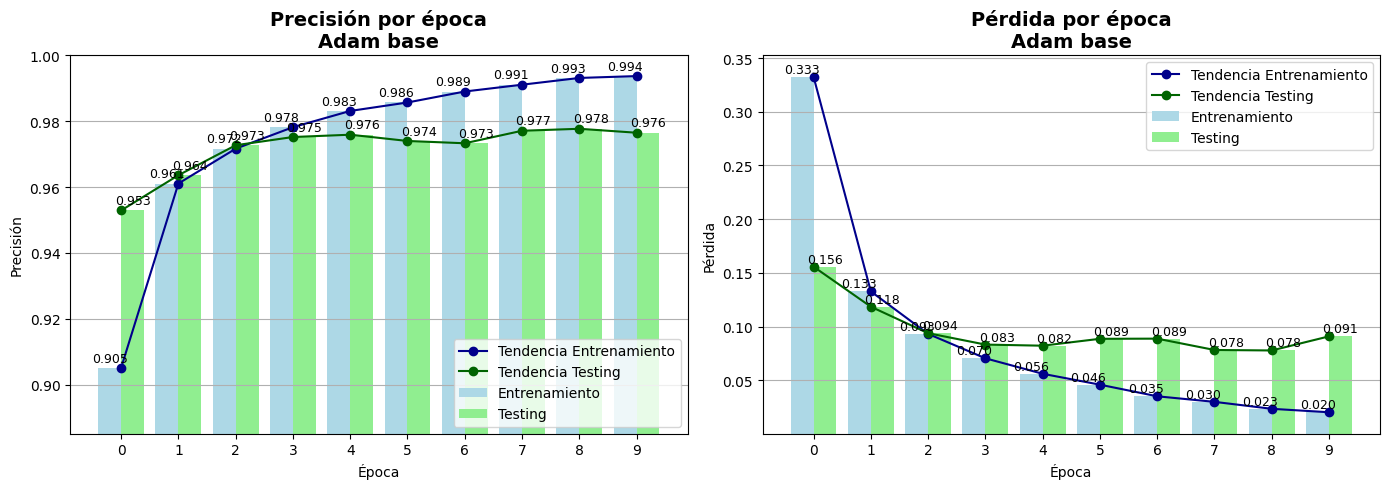

In [88]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_accuracy_bars(hist_adam, sub_titulo="Adam base", ax=axes[0])
plot_loss_bars(hist_adam, sub_titulo="Adam base", ax=axes[1])

plt.tight_layout()
plt.show()

In [33]:
generate_metrics_table_from_histories(hist_adam)

,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,0.020119,0.9937,0.994376,0.9931,0.993667,0.090824,0.9765,0.978034,0.9751,0.976416


In [34]:
print(f"Timepo de ejecución (segundos) MLP_adam: {time_adam}")

Timepo de ejecución (segundos) MLP_adam: 23.783798694610596


## Learning rate

Tomando como referencia el modelo base con optimizador Adam, se ajustó el learning rate a 0.01 con el objetivo de observar su impacto en el proceso de entrenamiento y en el rendimiento final del modelo.

In [35]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_learn = keras.Sequential(name="MLP_adam_learn")
red_adam_learn.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam_learn.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_learn.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_learn.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [36]:
time_start = time.time()

hist_adam_learn = red_adam_learn.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_learn = time.time() - time_start

hist_adam_learn.name = red_adam_learn.name
hist_models_adam.append(hist_adam_learn)


red_adam_learn.save("red_adam_learn.keras")

In [37]:
generate_metrics_table_from_histories([hist_adam,hist_adam_learn])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam,0.020119,0.99370,0.994376,0.99310,0.993667,0.090824,0.9765,0.978034,0.9751,0.976416
1,MLP_adam_learn,0.059964,0.98365,0.985612,0.98185,0.983555,0.164385,0.9698,0.972962,0.9680,0.969642


In [38]:
print(f"Timepo de ejecución (segundos) MLP_adam: {time_adam}")
print(f"Timepo de ejecución (segundos) MLP_adam_learn: {time_adam_learn}")


Timepo de ejecución (segundos) MLP_adam: 23.783798694610596
Timepo de ejecución (segundos) MLP_adam_learn: 15.667527198791504


### Evaluación learning rate

En esta ocasión no se va a implementar el laearning rate, ya que se puede visualizar una disminución de todas las métricas y un aumento de la perdida, a la vez que la diferencia del accuracy y entrenamiento es considerable en comparación al base lo cual nos indica un sobre entrenamiento

## Aumento de capas

Se aumentó la profundidad del modelo base con optimizador Adam a 4 capas ocultas, manteniendo el learning rate por defecto. Esta modificación busca evaluar cómo incide una mayor complejidad en la arquitectura sobre el rendimiento del modelo.

In [39]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_layers = keras.Sequential(name="MLP_adam_layers")
red_adam_layers.add(keras.layers.Dense(h1, input_dim=N, activation='relu', name='primera_capa'))
red_adam_layers.add(keras.layers.Dense(h2, activation='relu', name='segunda_capa'))
red_adam_layers.add(keras.layers.Dense(h2, activation='relu', name='tercera_capa'))
red_adam_layers.add(keras.layers.Dense(h2, activation='relu', name='cuarta_capa'))
red_adam_layers.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_layers.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [40]:
time_start = time.time()

hist_adam_layers = red_adam_layers.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_layers = time.time() - time_start

hist_adam_layers.name = red_adam_layers.name
hist_models_adam.append(hist_adam_layers)


red_adam_layers.save("red_adam_layers.keras")

In [41]:
generate_metrics_table_from_histories([hist_adam,hist_adam_layers])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam,0.020119,0.993700,0.994376,0.99310,0.993667,0.090824,0.9765,0.978034,0.9751,0.976416
1,MLP_adam_layers,0.024215,0.991783,0.992492,0.99145,0.991704,0.102946,0.9736,0.975634,0.9730,0.973313


In [42]:
print(f"Timepo de ejecución (segundos) MLP_adam: {time_adam}")
print(f"Timepo de ejecución (segundos) MLP_adam_layers: {time_adam_layers}")

Timepo de ejecución (segundos) MLP_adam: 23.783798694610596
Timepo de ejecución (segundos) MLP_adam_layers: 15.406338691711426


### Evaluación aumento de capas

A pesar que el valor del acuracy es similar en cuanto a valor y diferencia, al aumentar el número de capas se peude observar un aumento en la perdida esto se puede deber a (Inserte breve explicación), ademas de esto el resto de metricas no mejoran significativamente, por lo que no vale la pena aumentar el numero de capas haciendo el modelo mas complejo.

## Funciones de activación

Se modificó la función de activación del modelo base con optimizador Adam, reemplazando ReLU por tanh en las capas ocultas. No se aplicó aumento en la cantidad de capas, manteniéndose la estructura original. Esta variante permite analizar el impacto de la activación sobre el desempeño del modelo.

In [43]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_act = keras.Sequential(name="MLP_adam_act")
red_adam_act.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_adam_act.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_adam_act.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_act.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [44]:
time_start = time.time()

hist_adam_act = red_adam_act.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_act = time.time() - time_start

hist_adam_act.name = red_adam_act.name
hist_models_adam.append(hist_adam_act)

red_adam_act.save("red_adam_act.keras")

In [45]:
generate_metrics_table_from_histories([hist_adam,hist_adam_act])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam,0.020119,0.993700,0.994376,0.993100,0.993667,0.090824,0.9765,0.978034,0.9751,0.976416
1,MLP_adam_act,0.019745,0.995033,0.995744,0.994233,0.995027,0.075456,0.9770,0.978832,0.9757,0.976864


In [46]:
print(f"Timepo de ejecución (segundos) MLP_adam: {time_adam}")
print(f"Timepo de ejecución (segundos) MLP_adam_act: {time_adam_act}")

Timepo de ejecución (segundos) MLP_adam: 23.783798694610596
Timepo de ejecución (segundos) MLP_adam_act: 21.164578199386597


### Evaluación función de activación

La diferencia no es enorme, pero la función de activación en MLP_adam_act está ayudando a mejorar tanto las métricas en el conjunto de entrenamiento como en el conjunto de validación, lo que sugiere que el modelo con activación podría estar generalizando mejor, debido a esto el resto de pruebas se realizara con la función de activación tanh.

## Tamaño del batch

In [47]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 3 capas escondidas!)

h1 = 128
h2 = 64

red_adam_batch = keras.Sequential(name="MLP_adam_batch_tahn")
red_adam_batch.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_adam_batch.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_adam_batch.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_batch.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

In [48]:
time_start = time.time()
hist_adam_batch = red_adam_batch.fit(X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_batch = time.time() - time_start

hist_adam_batch.name = red_adam_batch.name
hist_models_adam.append(hist_adam_batch)


red_adam_batch.save("red_adam_batch.keras")


In [49]:
generate_metrics_table_from_histories([hist_adam_act, hist_adam_batch])

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam_act,0.019745,0.995033,0.995744,0.994233,0.995027,0.075456,0.9770,0.978832,0.9757,0.976864
1,MLP_adam_batch_tahn,0.017124,0.994567,0.995079,0.994133,0.994529,0.089939,0.9772,0.978849,0.9765,0.977003


In [50]:
print(f"Timepo de ejecución (segundos) MLP_adam_act: {time_adam_act}")
print(f"Timepo de ejecución (segundos) MLP_adam_batch_tahn: {time_adam_batch}")

Timepo de ejecución (segundos) MLP_adam_act: 21.164578199386597
Timepo de ejecución (segundos) MLP_adam_batch_tahn: 46.173877477645874


### Evaluación batch

## Dropout

In [51]:
# Setea los seed para números random

np.random.seed(12)
tf.random.set_seed(12)


# Se crea la red feed-forward (tiene 2 capas escondidas!)

h1 = 128
h2 = 64

red_adam_drop = keras.Sequential(name="MLP_adam_drop_tanh")
red_adam_drop.add(keras.layers.Dense(h1, input_dim=N, activation='tanh', name='primera_capa'))
red_adam_drop.add(keras.layers.Dropout(0.3))
red_adam_drop.add(keras.layers.Dense(h2, activation='tanh', name='segunda_capa'))
red_adam_drop.add(keras.layers.Dense(C, activation='softmax', name='capa_de_salida'))


red_adam_drop.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy', 'Precision', 'Recall', 'F1Score']
)

Justificación de las configuraciones utilizadas.

In [52]:
time_start = time.time()
hist_adam_drop = red_adam_drop.fit(X_train, y_train,
        epochs=10,
        batch_size=128,
        validation_data=(X_test,y_test),
        verbose=0
        )
time_adam_drop = time.time() - time_start

hist_adam_drop.name = red_adam_drop.name
hist_models_adam.append(hist_adam_drop)


red_adam_drop.save("red_adam_drop.keras")

## Métricas

In [53]:
generate_metrics_table_from_histories(hist_models_adam)

,Modelo,loss,accuracy,precision,recall,f1_score,val_loss,val_accuracy,val_precision,val_recall,val_f1_score
0,MLP_adam,0.020119,0.993700,0.994376,0.993100,0.993667,0.090824,0.9765,0.978034,0.9751,0.976416
1,MLP_adam_learn,0.059964,0.983650,0.985612,0.981850,0.983555,0.164385,0.9698,0.972962,0.9680,0.969642
2,MLP_adam_layers,0.024215,0.991783,0.992492,0.991450,0.991704,0.102946,0.9736,0.975634,0.9730,0.973313
3,MLP_adam_act,0.019745,0.995033,0.995744,0.994233,0.995027,0.075456,0.9770,0.978832,0.9757,0.976864
4,MLP_adam_batch_tahn,0.017124,0.994567,0.995079,0.994133,0.994529,0.089939,0.9772,0.978849,0.9765,0.977003
5,MLP_adam_drop_tanh,0.090905,0.971967,0.976755,0.967850,0.971722,0.092056,0.9722,0.976330,0.9693,0.971945


En teroria podria ser el de función de activación, a pesar de que el que aplica dropout tiene menor diferencia entre los accuracy de train y testing (lo que indica menos overfitting), tiene menor capacidad predectiva global ya que el f1 score y el recall son, mas bajos y tiene mayor perdida. [REVISAR]

In [54]:
redes_adam = ['red_adam', 'red_adam_learn', 'red_adam_layers', 'red_adam_act', 'red_adam_batch', 'red_adam_drop']

tabla = extraer_info_redes(redes_adam)
tabla

,Nombre Red,Función de Activación,Tasa de Dropout,Optimizador,Learning Rate
0,MLP_adam,relu,0.0,Adam,0.001
1,MLP_adam_learn,relu,0.0,Adam,0.010
2,MLP_adam_layers,relu,0.0,Adam,0.001
3,MLP_adam_act,tanh,0.0,Adam,0.001
4,MLP_adam_batch_tahn,tanh,0.0,Adam,0.001
5,MLP_adam_drop_tanh,tanh,0.3,Adam,0.001


# Evaluación del modelo:

Uso de métricas como accuracy, precision, recall y F1-score.

# Optimizador: SGD + Momentum

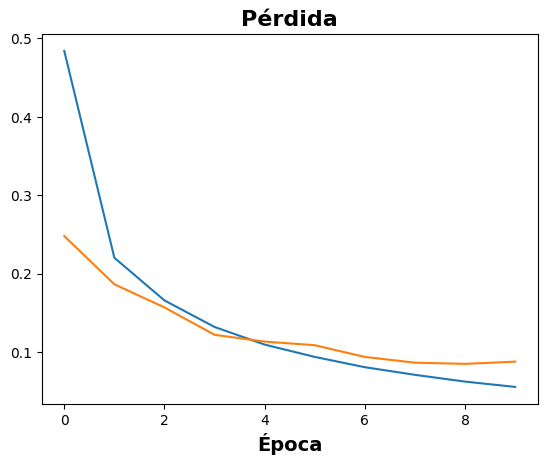

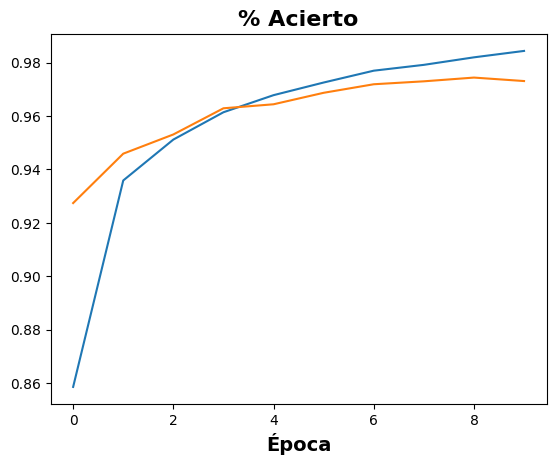

In [55]:
plt.plot(hist_sgd.history['loss'])
plt.plot(hist_sgd.history['val_loss'])
plt.title('Pérdida', fontweight="bold", fontsize=16)
plt.xlabel('Época', fontweight="bold", fontsize=14)
plt.show()

plt.plot(hist_sgd.history['accuracy'])
plt.plot(hist_sgd.history['val_accuracy'])
plt.title('% Acierto', fontweight="bold", fontsize=16)
plt.xlabel('Época', fontweight="bold", fontsize=14)
plt.show()

## Gráficos de precisión

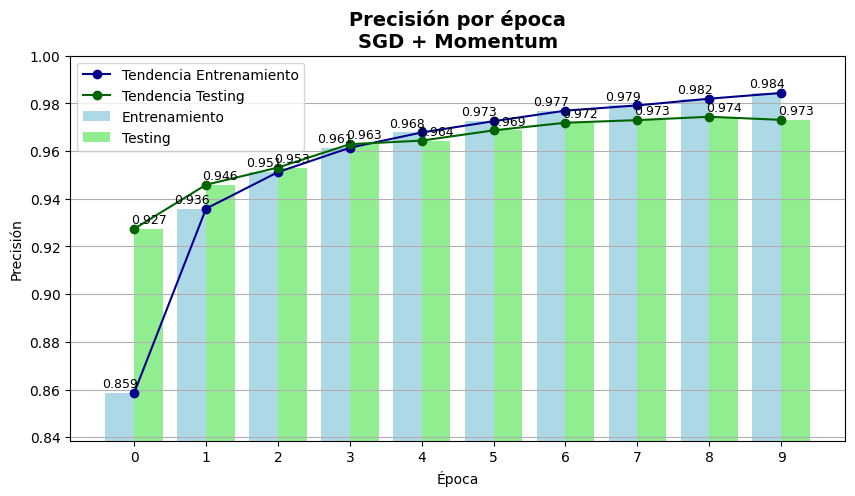

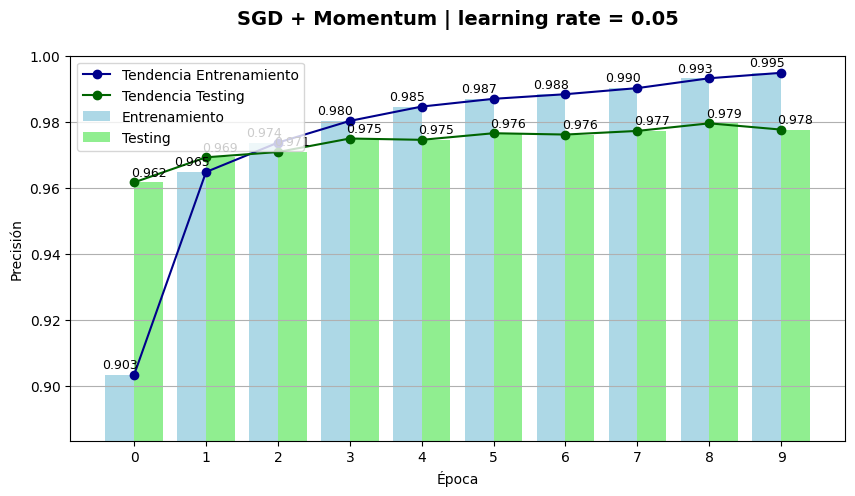

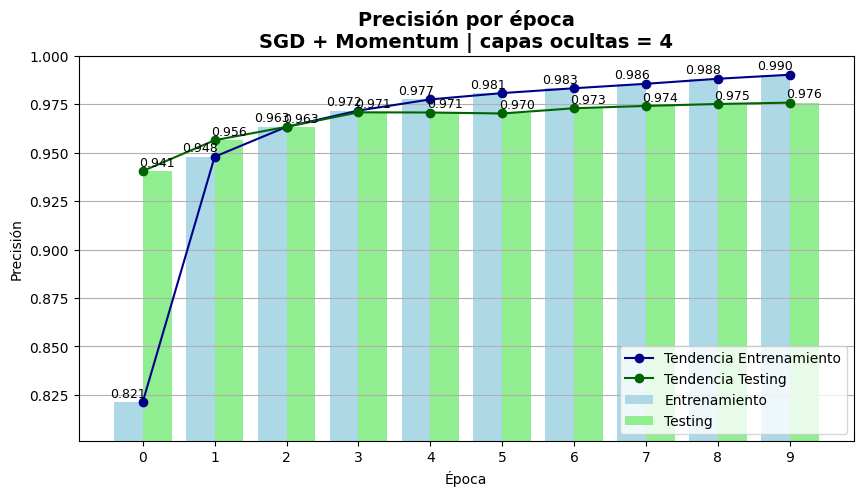

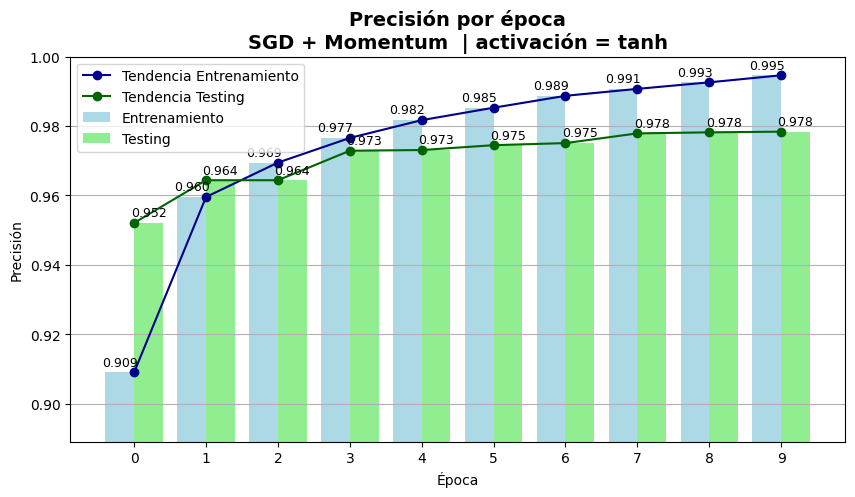

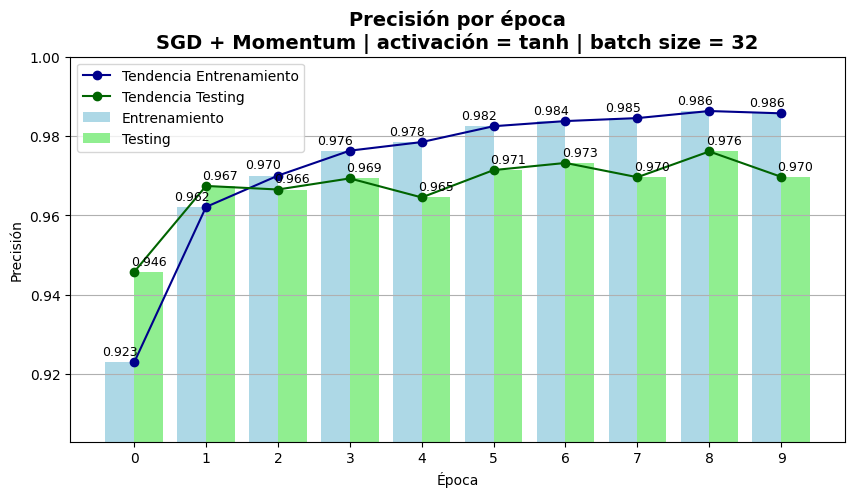

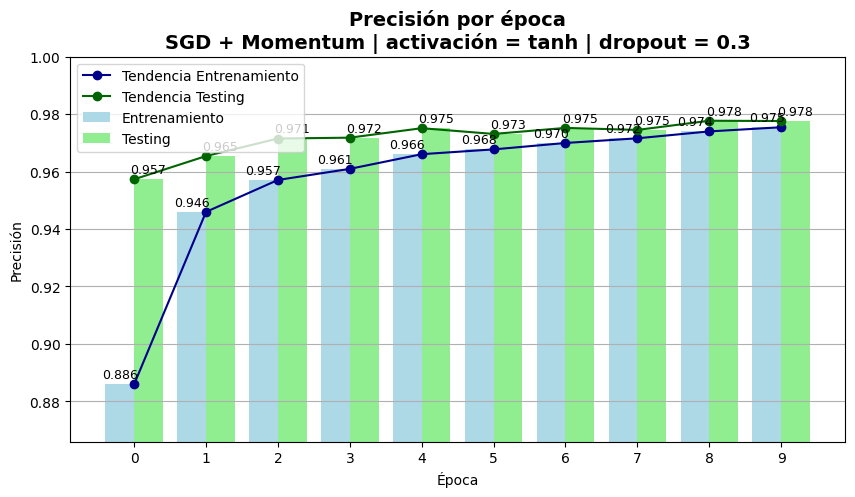

In [94]:
plot_accuracy_bars(hist_sgd, sub_titulo="SGD + Momentum")
plot_accuracy_bars(hist_sgd_learn, titulo="SGD + Momentum | learning rate = 0.05")
plot_accuracy_bars(hist_sgd_layers, sub_titulo="SGD + Momentum | capas ocultas = 4")
plot_accuracy_bars(hist_sgd_act, sub_titulo="SGD + Momentum  | activación = tanh")
plot_accuracy_bars(hist_sgd_act_batch, sub_titulo="SGD + Momentum | activación = tanh | batch size = 32")
plot_accuracy_bars(hist_sgd_act_drop, sub_titulo="SGD + Momentum | activación = tanh | dropout = 0.3")

## Gráfico de perdida 

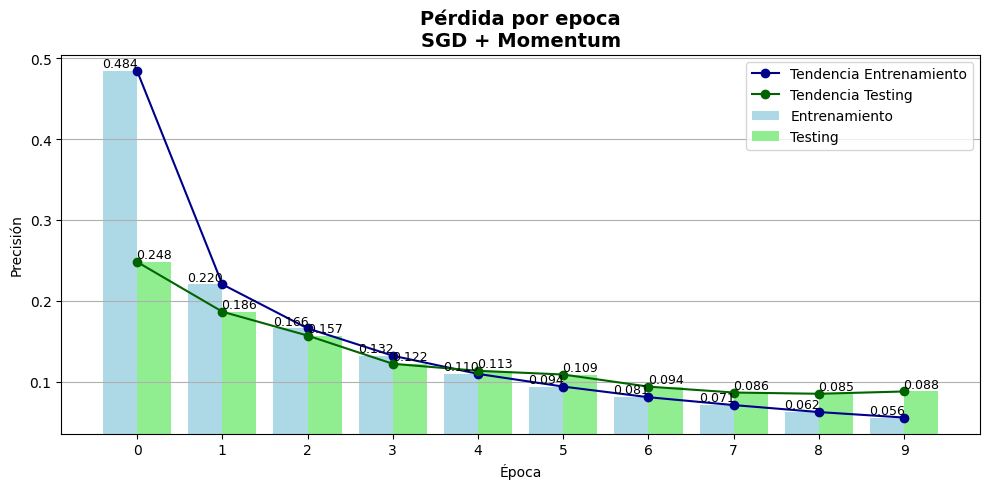

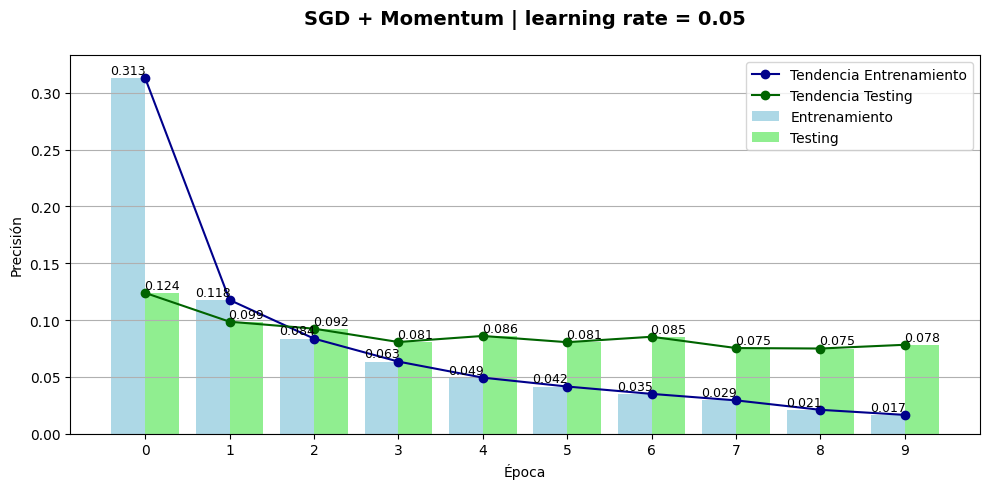

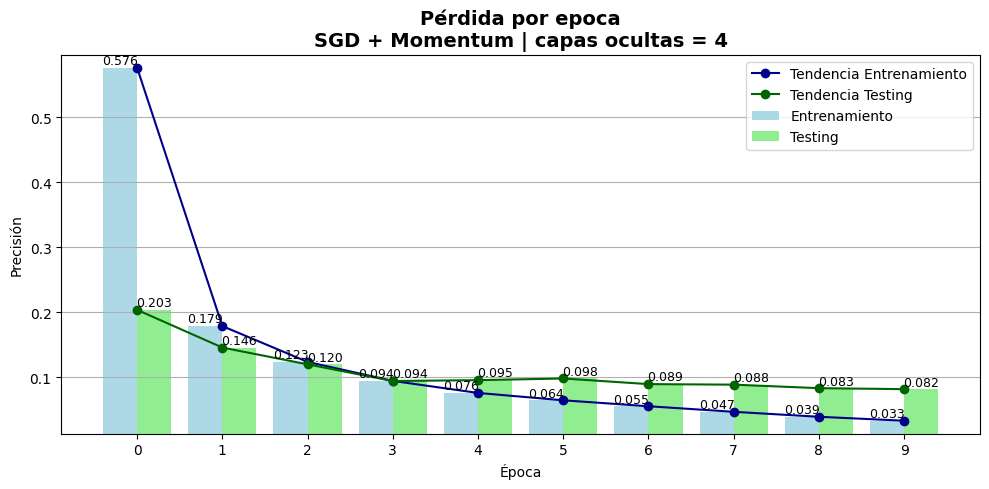

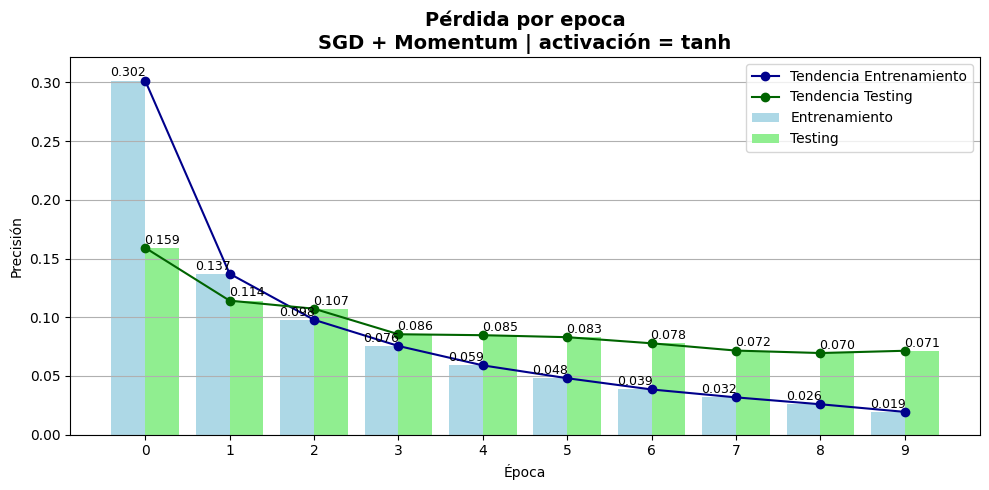

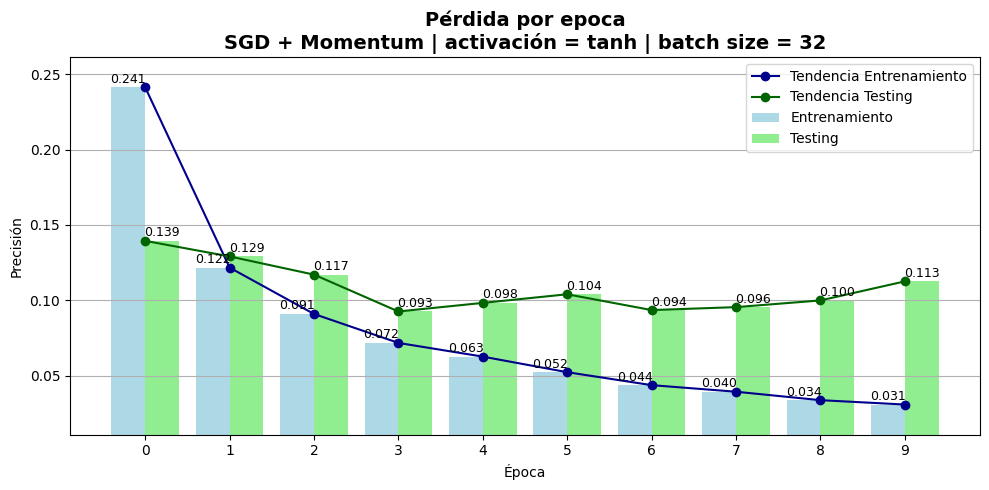

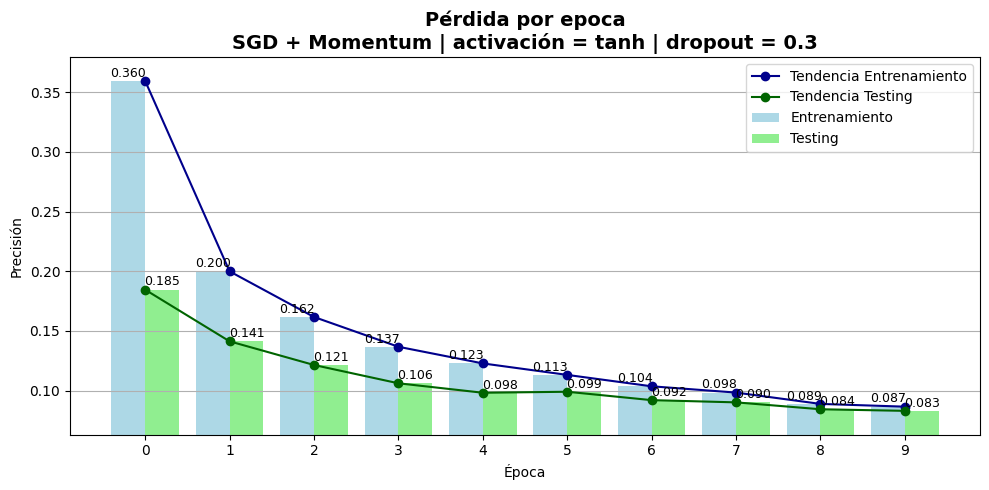

In [57]:
plot_loss_bars(hist_sgd, sub_titulo="SGD + Momentum")
plot_loss_bars(hist_sgd_learn, titulo="SGD + Momentum | learning rate = 0.05")
plot_loss_bars(hist_sgd_layers, sub_titulo="SGD + Momentum | capas ocultas = 4")
plot_loss_bars(hist_sgd_act, sub_titulo="SGD + Momentum | activación = tanh")
plot_loss_bars(hist_sgd_act_batch, sub_titulo="SGD + Momentum | activación = tanh | batch size = 32")
plot_loss_bars(hist_sgd_act_drop, sub_titulo="SGD + Momentum | activación = tanh | dropout = 0.3")

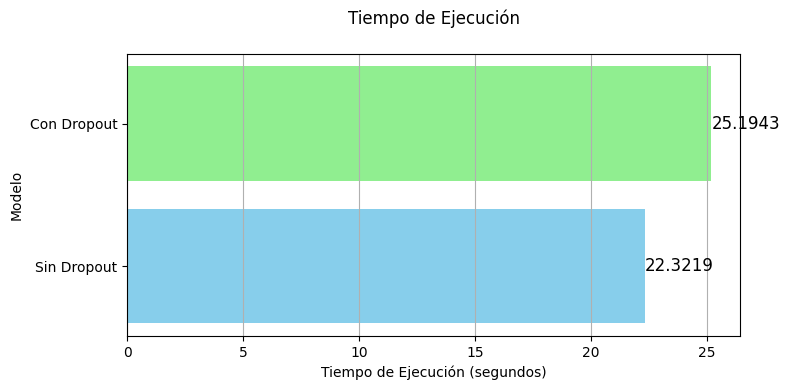

In [58]:
tiempos = [time_sgd, time_sgd_act_drop]
plot_execution_times(tiempos, titulo="Tiempo de Ejecución", sub_titulo="")

# Adam

## Graficos de precisión

Grafico para ver el sobreeentrenamiento entre las epocas

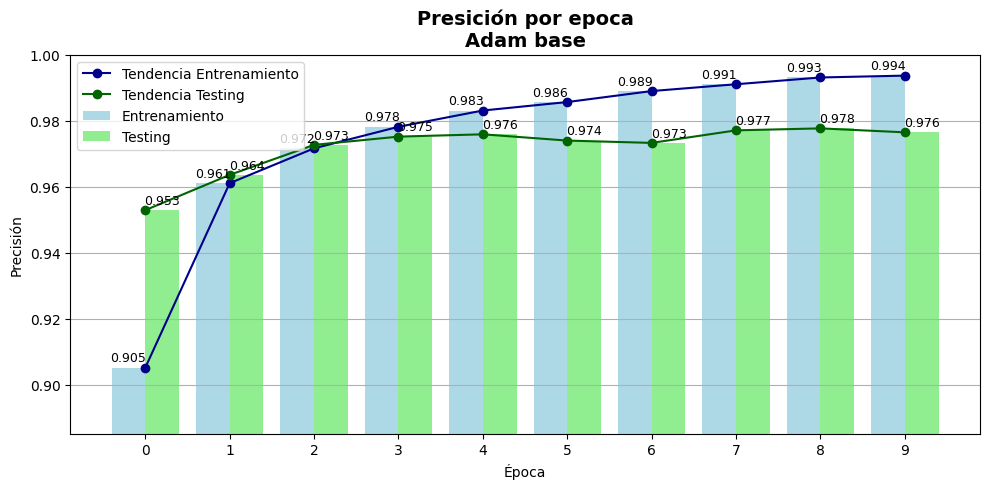

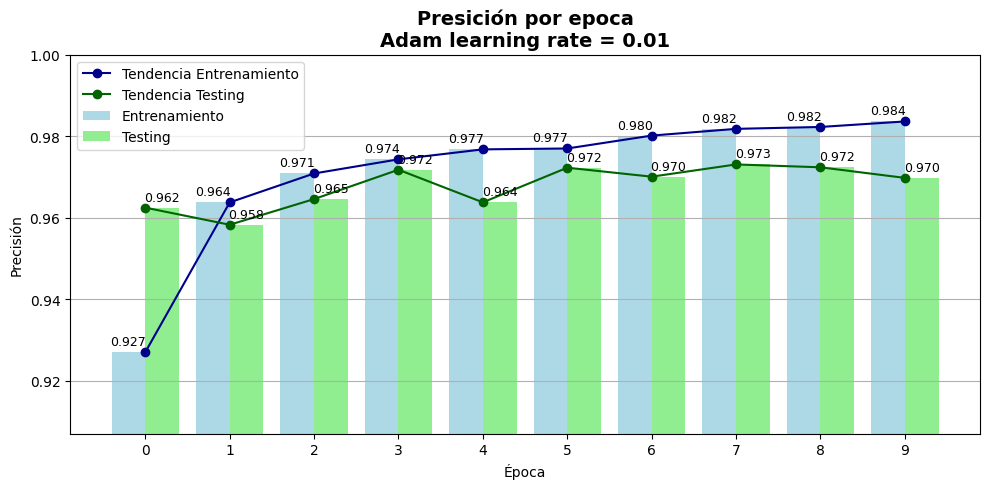

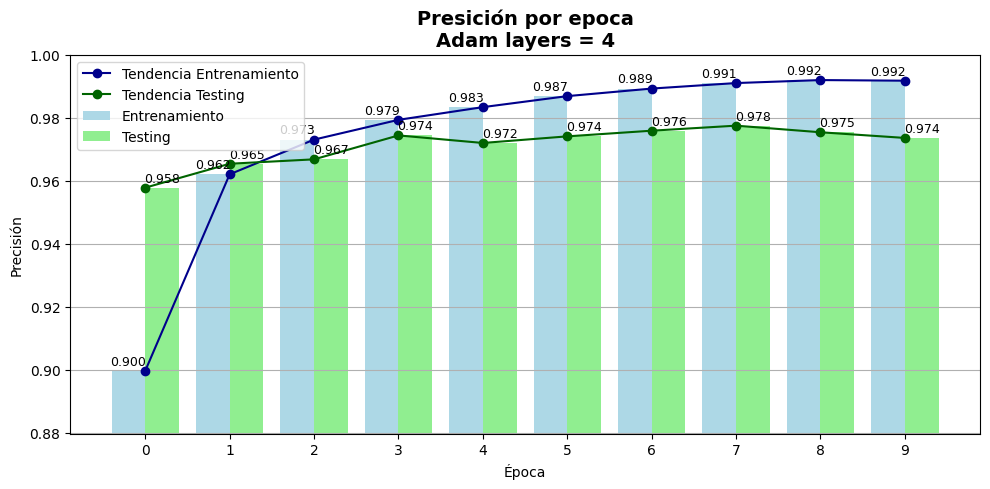

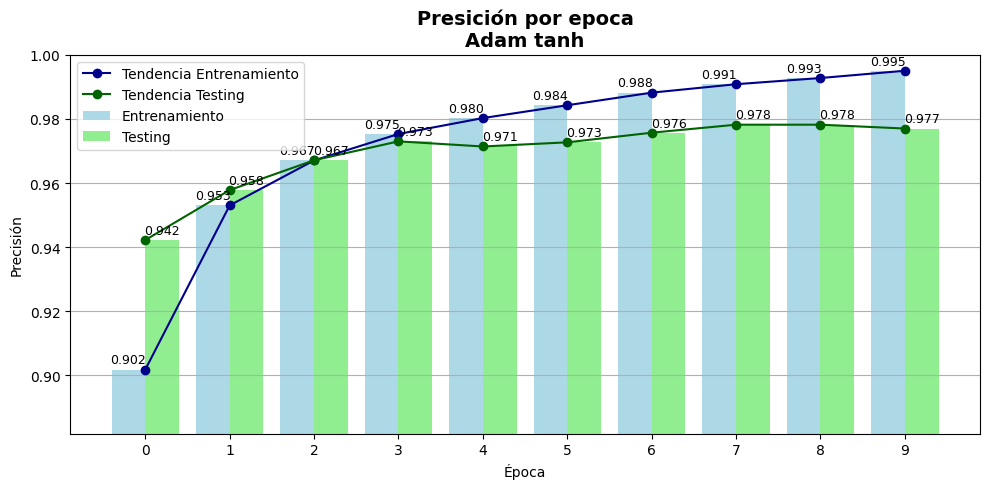

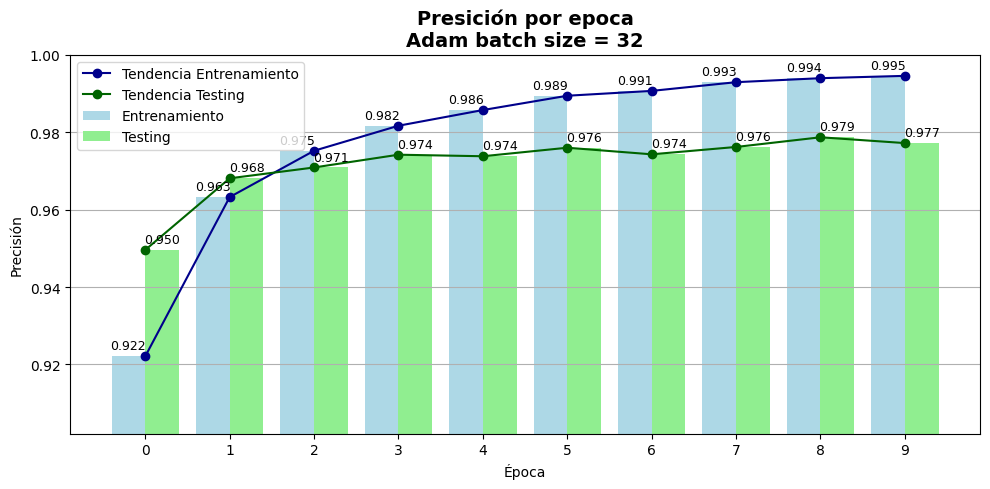

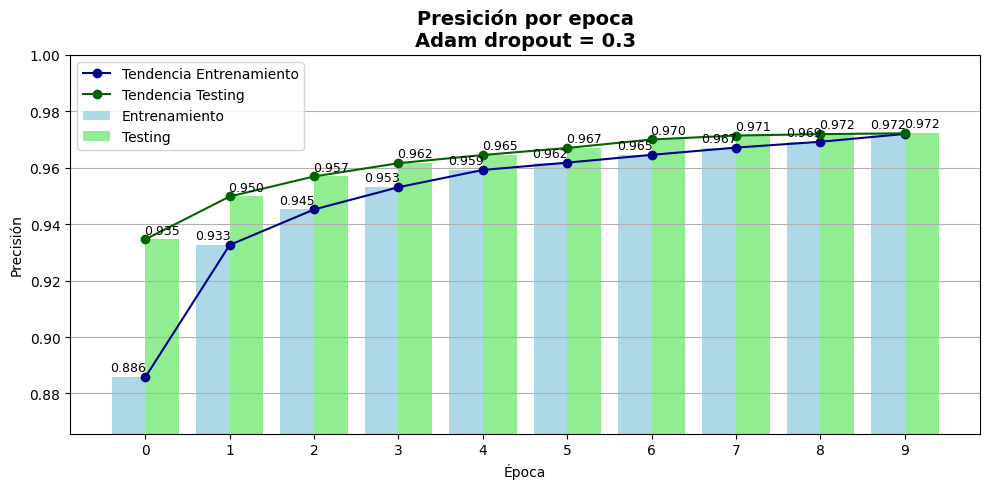

In [59]:
plot_accuracy_bars(hist_adam, sub_titulo="Adam base")
plot_accuracy_bars(hist_adam_learn, sub_titulo="Adam learning rate = 0.01")
plot_accuracy_bars(hist_adam_layers, sub_titulo="Adam layers = 4")
plot_accuracy_bars(hist_adam_act, sub_titulo="Adam tanh")
plot_accuracy_bars(hist_adam_batch, sub_titulo="Adam batch size = 32")
plot_accuracy_bars(hist_adam_drop, sub_titulo="Adam dropout = 0.3")




## Gráfico de perdida

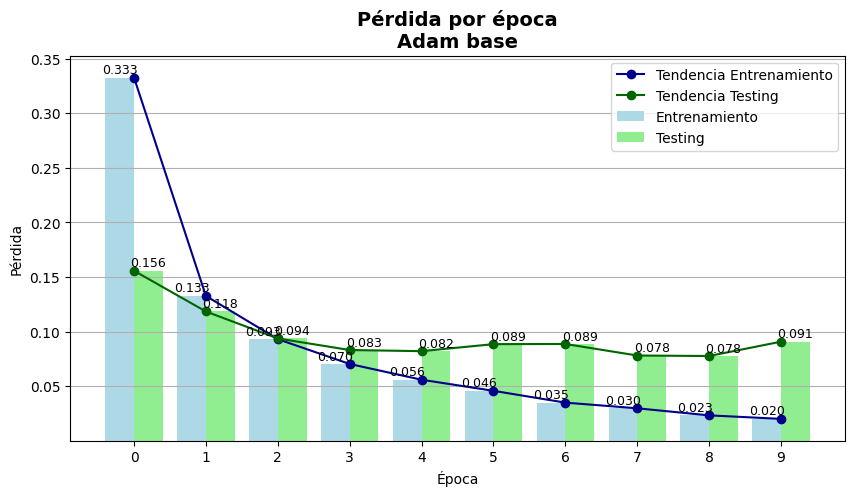

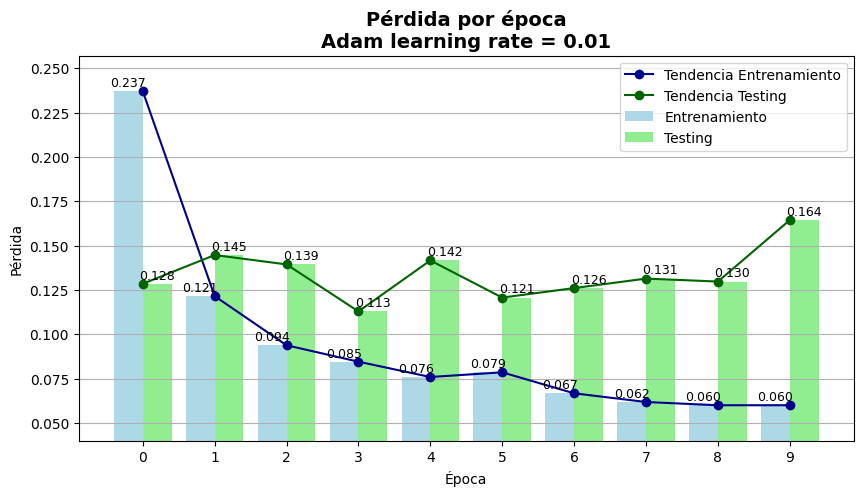

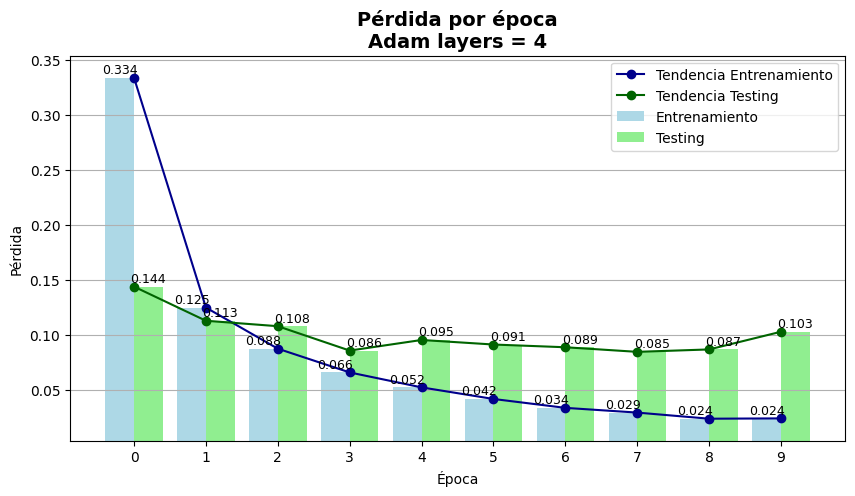

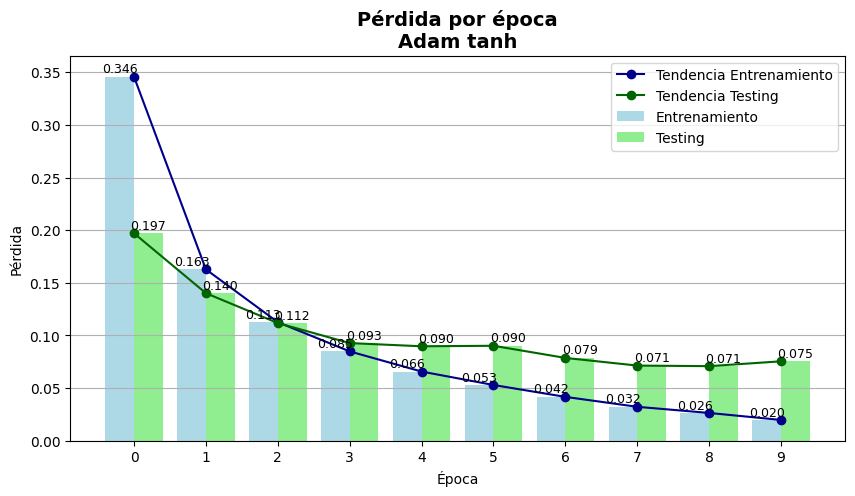

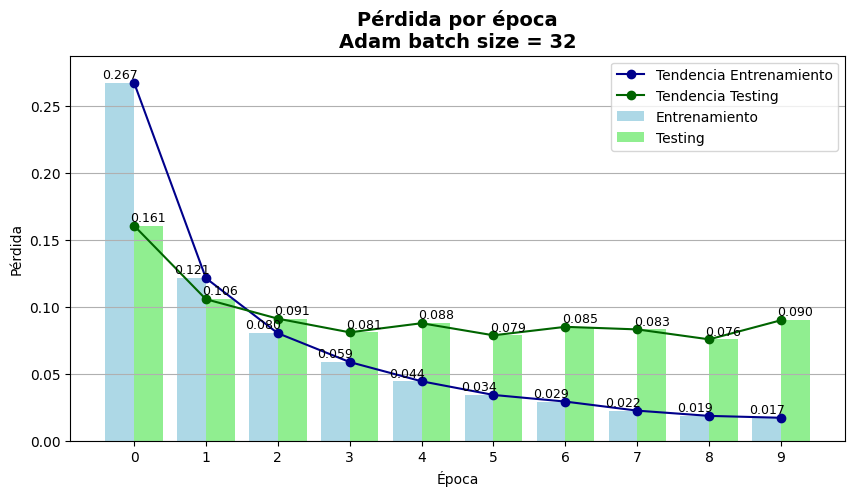

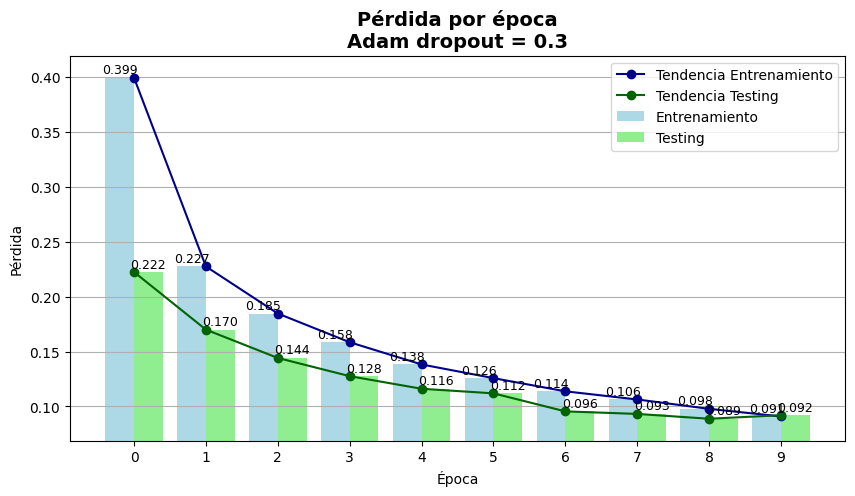

In [85]:
plot_loss_bars(hist_adam, sub_titulo="Adam base")
plot_loss_bars(hist_adam_learn, sub_titulo="Adam learning rate = 0.01")
plot_loss_bars(hist_adam_layers, sub_titulo="Adam layers = 4")
plot_loss_bars(hist_adam_act, sub_titulo="Adam tanh")
plot_loss_bars(hist_adam_batch, sub_titulo="Adam batch size = 32")
plot_loss_bars(hist_adam_drop, sub_titulo="Adam dropout = 0.3")

## Comparación dropout

# Análisis y mejora del modelo:

Comparación de distintas configuraciones y ajustes realizados.

# Conclusiones:

Reflexión sobre el desempeño del modelo y posibles mejoras.

# Carga, evaluación y predicción de un modelo

In [53]:
# Evaluar modelo
loaded_model = load_model('red_sgd_l005_actTanh.keras')

results = loaded_model.evaluate(X_test, y_test)

print("Test results:")
for metric_name, result in zip(loaded_model.metrics_names, results):
    print(f"{metric_name}: {result}")

# Con dibujo propio (Este fue generado por la "app" de dibujo. El dibujo es un 4)
img_array = np.load("./saved_image.npy")

prediction = loaded_model.predict(img_array)
print("\nData propia:")
print(int(np.argmax(prediction)))

313/313 [==============================] - 1s 1ms/step - loss: 0.0730 - accuracy: 0.9780 - precision: 0.9798 - recall: 0.9761 - f1_score: 0.9778
Test results:
loss: 0.07296355068683624
accuracy: 0.9779999852180481
precision: 0.9798233509063721
recall: 0.9761000275611877
f1_score: [0.9843197  0.98991674 0.9746094  0.9748996  0.9786369  0.97390336
 0.9780105  0.9753266  0.97686374 0.971684  ]
1/1 [==============================] - 0s 62ms/step

Data propia:
4


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9dc7e3b2-3914-4a2d-83b3-47dbec5af292' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>